In [1]:
import json
from StringIO import StringIO
import pandas as pd
import openpyxl

In [2]:
import pandas as pd
import os
import sklearn as sk
from sklearn.linear_model import MultiTaskLasso, MultiTaskElasticNet, ElasticNet
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import sklearn.metrics as skmet
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords, names
import datetime
from scipy.stats import ttest_ind 
import csv

In [3]:
from sklearn.cluster import KMeans

In [4]:
listings_augmented_2018 = pd.read_csv('Datasources\listings_augmented\listings_augmented_2018-05-19_V5.csv', low_memory = False)

In [5]:
listings_augmented_2018 = listings_augmented_2018.drop('distance_from_ocean', axis = 1)

In [6]:
listings_augmented_2018['distance_from_ocean'] = 0
listings_augmented_2018['distance_from_ocean'] = listings_augmented_2018['distance_from_ocean'].astype('float')
    
for w in listings_augmented_2018.index:
    p = float(listings_augmented_2018['latitude'][w])
    q = float(listings_augmented_2018['longitude'][w])
    lon_diff = (q + 117.235585)*np.pi/180
    lat_diff = (p - 32.802458)*np.pi/180
    a = np.sin(lat_diff/2)**2 + np.cos(p*np.pi/180)*np.cos(32.802458*np.pi/180)*(np.sin(lon_diff/2)**2)
    c = np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    d = 6371.00*float(c)
    listings_augmented_2018['distance_from_ocean'][w] = d

C:\Users\sanka\Anaconda2\envs\py27\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
listings_augmented_numeric = listings_augmented_2018.select_dtypes(include=['float64', 'int64'])

In [13]:
listings_augmented_numeric = listings_augmented_numeric.fillna(0)

In [14]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(listings_augmented_numeric)

In [15]:
kmeans.labels_

array([5, 8, 7, ..., 9, 2, 0])

In [16]:
class_cluster_dictionary = {}

for i in range(10):
    class_cluster_dictionary[i] = []

In [20]:
for i in range(len(listings_augmented_numeric)):
    key = kmeans.labels_[i]
    v = listings_augmented_numeric['id'][i]
    
    class_cluster_dictionary[key].append(v)

In [28]:
kmeans.cluster_centers_

array([[  1.45842697e-01,   5.40449438e-02,   2.38327091e-02, ...,
          8.48938826e-02,   1.14856429e-01,   4.36924817e+00],
       [  1.00000000e+02,   1.00000000e+02,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   6.26158408e+03],
       [  1.40705596e-01,   3.66180049e-02,   1.99026764e-02, ...,
         -3.46944695e-16,  -1.45716772e-16,   4.39793231e+00],
       ..., 
       [  1.29854772e-01,   4.46473029e-02,   2.52385892e-02, ...,
          1.49377593e-01,   1.98132780e-01,   4.13263003e+00],
       [  1.65536993e-01,   3.30548926e-02,   2.59427208e-02, ...,
         -3.40005801e-16,  -1.45716772e-16,   4.81073362e+00],
       [  1.43795181e-01,   3.91967871e-02,   2.60843373e-02, ...,
         -1.24900090e-16,  -1.52655666e-16,   4.79221812e+00]])

In [29]:
import matplotlib.pyplot as plt

In [30]:
colors = kmeans.labels_

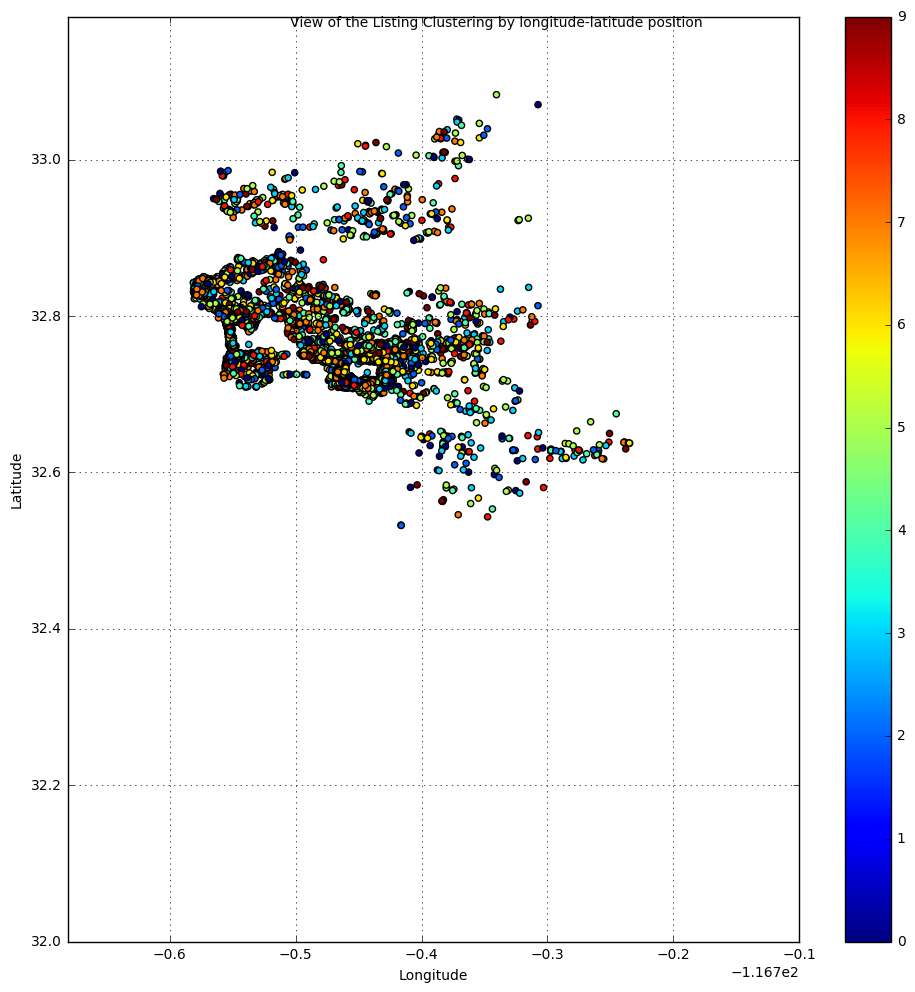

In [43]:
fig, ax = plt.subplots(figsize = (10, 10))
l = ax.scatter(listings_augmented_numeric['longitude'], listings_augmented_numeric['latitude'], c = colors)
fig.colorbar(l)
ax.set_xlim((listings_augmented_numeric['longitude'].min() - .1, -116.8))
ax.set_ylim((32, listings_augmented_numeric['latitude'].max() + .1))
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
fig.suptitle('View of the Listing Clustering by longitude-latitude position')
fig.tight_layout(pad = 1)
ax.grid(True)
plt.show()

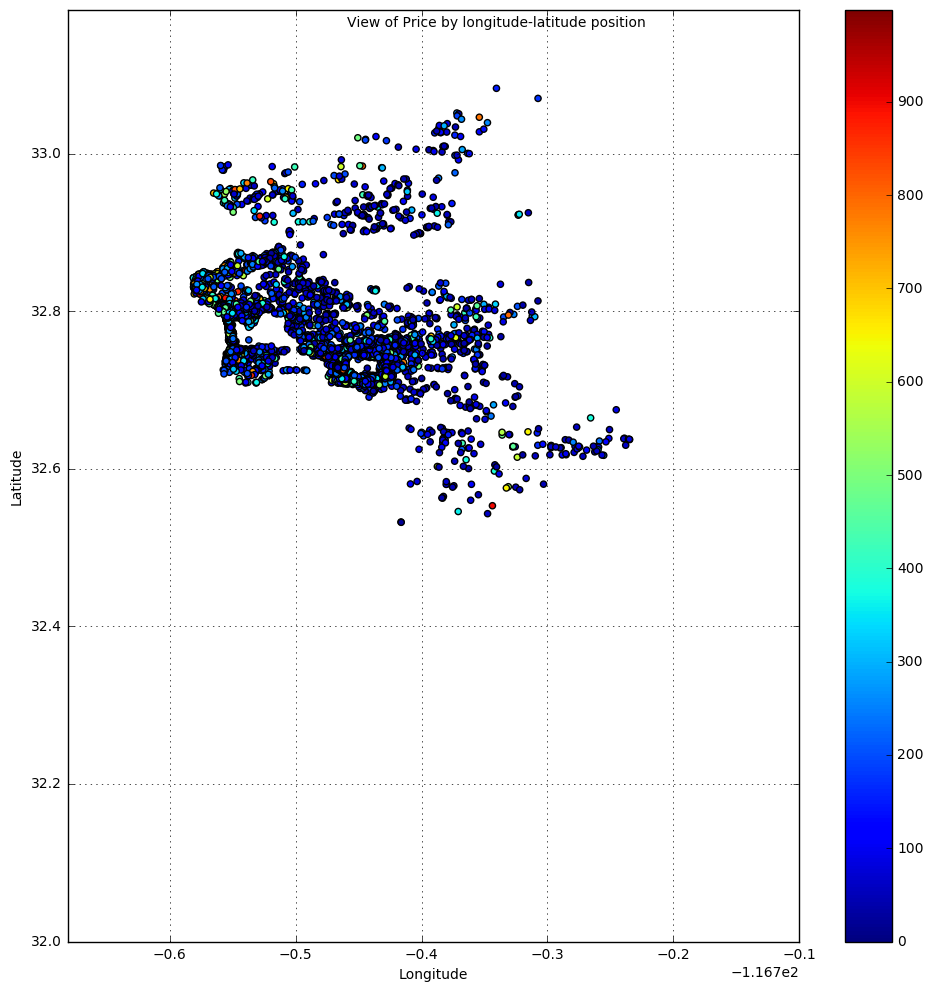

In [47]:
fig, ax = plt.subplots(figsize = (10, 10))
l = ax.scatter(listings_augmented_numeric['longitude'], listings_augmented_numeric['latitude'], c = listings_augmented_numeric['price_y'])
fig.colorbar(l)
ax.set_xlim((listings_augmented_numeric['longitude'].min() - .1, -116.8))
ax.set_ylim((32, listings_augmented_numeric['latitude'].max() + .1))
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
fig.suptitle('View of Price by longitude-latitude position')
fig.tight_layout(pad = 1)
ax.grid(True)
plt.show()

In [51]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

In [52]:
label_enc = LabelEncoder()

In [55]:
bed_type_enc = label_enc.fit_transform(listings_augmented_2018['room_type'])

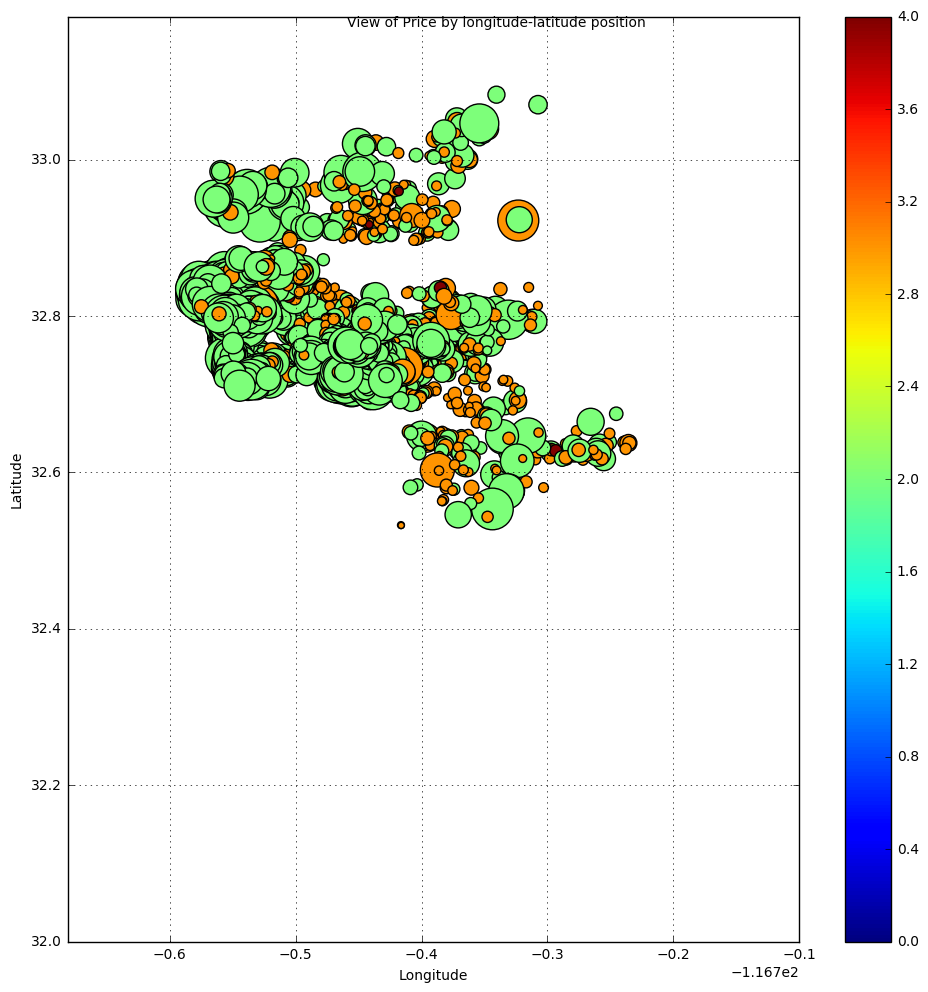

In [56]:
fig, ax = plt.subplots(figsize = (10, 10))
l = ax.scatter(listings_augmented_numeric['longitude'], listings_augmented_numeric['latitude'], s = listings_augmented_numeric['price_y'], c = bed_type_enc)
fig.colorbar(l)
ax.set_xlim((listings_augmented_numeric['longitude'].min() - .1, -116.8))
ax.set_ylim((32, listings_augmented_numeric['latitude'].max() + .1))
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
fig.suptitle('View of Price by longitude-latitude position')
fig.tight_layout(pad = 1)
ax.grid(True)
plt.show()

In [64]:
# A mapping of the encoding

K = []

for w in zip(listings_augmented_2018['room_type'], bed_type_enc):
    if w not in K:
        K.append(w)
        
K

[('Private room', 3),
 ('Entire home/apt', 2),
 ('Shared room', 4),
 (nan, 0),
 ('1.0', 1)]

In [65]:
bed_type_enc = label_enc.fit_transform(listings_augmented_2018['bed_type'])

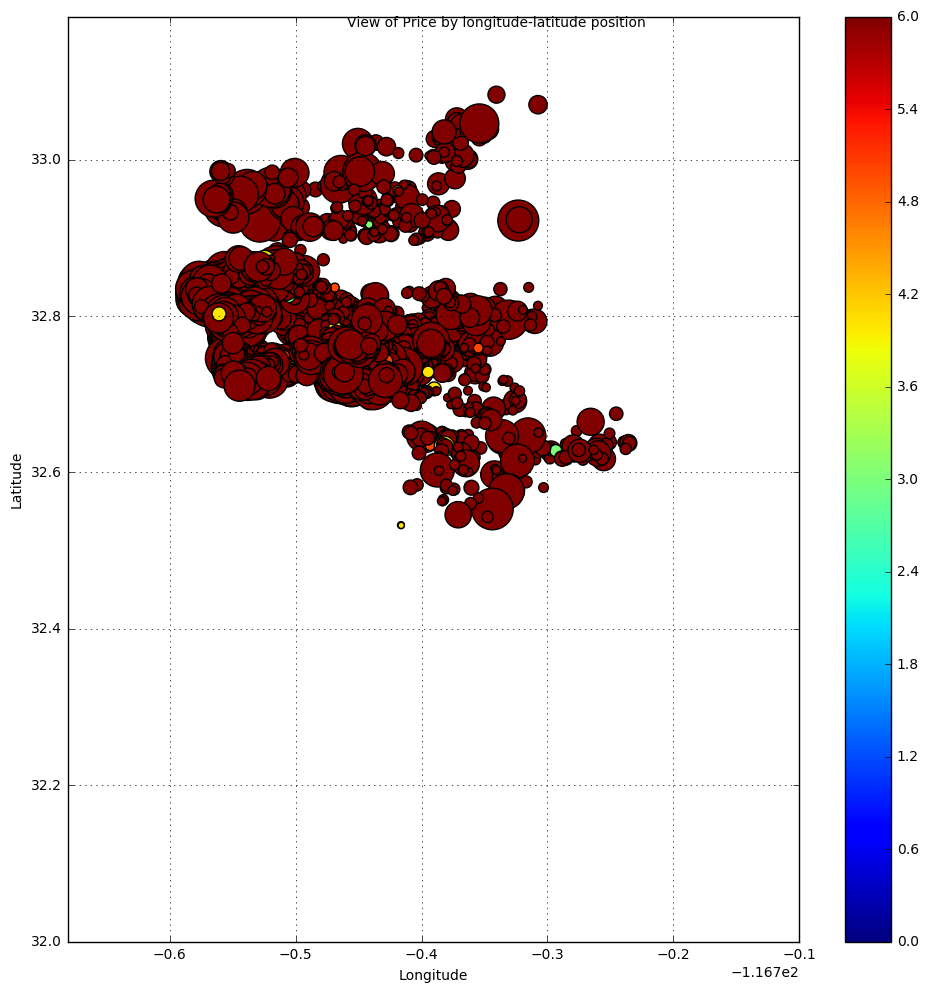

In [66]:
fig, ax = plt.subplots(figsize = (10, 10))
l = ax.scatter(listings_augmented_numeric['longitude'], listings_augmented_numeric['latitude'], s = listings_augmented_numeric['price_y'], c = bed_type_enc)
fig.colorbar(l)
ax.set_xlim((listings_augmented_numeric['longitude'].min() - .1, -116.8))
ax.set_ylim((32, listings_augmented_numeric['latitude'].max() + .1))
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
fig.suptitle('View of Price by longitude-latitude position')
fig.tight_layout(pad = 1)
ax.grid(True)
plt.show()

In [67]:
L = []
for w in bed_type_enc:
    if w not in L:
        L.append(w)
        
L

[6, 3, 2, 5, 4, 0, 1]

In [68]:
K = []

for w in zip(listings_augmented_2018['bed_type'], bed_type_enc):
    if w not in K:
        K.append(w)
        
K

[('Real Bed', 6),
 ('Couch', 3),
 ('Airbed', 2),
 ('Pull-out Sofa', 5),
 ('Futon', 4),
 (nan, 0),
 ('0.0', 1)]